In [28]:
import cv2
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import AdditiveChi2Sampler
import pickle
from sklearn.svm import SVC
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

NOTE: Above every code cell is a markdown stating the purpose of the code and the reason for that particular code. 

PURPOSE: Used map for mapping number to emotions. 
REASON: Since the naming convention of video files is number 01-08 for emotions, mapping the numbers to the emotion is necessary for labelling. 

In [2]:
train_folder='TRAIN'
test_folder='TEST'

emotion_mapping={"01": "Neutral","02": "Calm","03": "Happy","04": "Sad","05": "Angry","06": "Fearful","07": "Disgust","08": "Surprised"}



PURPOSE: Detecting faces in a video file frame by frame. The frames are converted to grayscale because face detection models work better with gray images. 
scaleFactor scales the face images in all frames to the same size to account for difference in face size of different actors, minNeighbours includes the given number of neighbours in the rectangle-used to remove false positives, and minSize sets the minimum size of the images to be considered.

REASON: To detect the emotion from a video, it is necessary to detect the faces in the video. Many other components like a wall, ornaments etc. can be present that are of no use. 

In [21]:
def face_detection(one_frame):
    haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(haar_cascade_path)
    gray = cv2.cvtColor(one_frame, cv2.COLOR_BGR2GRAY)  # face detection works better with gray images
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)) #scale the 
    return faces


PURPOSE: Function for video file processing. The processing includes- 1. Face detection  2. extracting LBP features to prepare the dataset for running in the model.

REASON: The given dataset is videos for training and testing. We need to extract features and label them to be able to train the model and test it. As the paper suggests, face detection is done and LBP features are extracted. Face alignment step is not done because the result using the aligned and not aligned features was the same.


In [22]:
def video_processing(video_path):
    video_capture=cv2.VideoCapture(video_path)
    LBP_features=[]
    while video_capture.isOpened():
        ret, frame=video_capture.read()
        if not ret:
            break
        faces=face_detection(frame)  #detecting faces-> faces are the detected faces which can now be used to extract lbp features
        # Extract features for each face
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (128, 128))
           
            gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")  #here, LBP features are being extracted
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), density=True) #hist is the lbp feature extracted
            LBP_features.append(hist)
    video_capture.release() #releasing captured frames to clear space
    return np.mean(LBP_features, axis=0) if LBP_features else np.zeros((26,))    #if no LBP features are extracted, an array of size 26 of 0s is returned. 26 is the expected size of the LBP feature array.
#the size 26 is meant as padding as the extracted feature array can be of different lengths  

PURPOSE: The given code snippet feeds the videos into the video processing function for face detection and LBP feature extraction. From the train set, 300 videos - every (repeated video skipped) is fed into the function. total test set - 2400 videos

REASON: Due to large dataset size and time taken for feature extraction, we take 300 out of 2400 videos (12.5%) to across 5 folders-> 60 x 5 =300. Every alternate cideo is skipped because each video is repeated twice(noted from the naming convention of the videos)

In [29]:
x=[]
y=[]
max_vids=300  # we are processing 300 videos from the train set
current=0
odd=0   # so that repetitive videos are not taken
for actor_folder in os.listdir(train_folder):
    if current >= max_vids:  # stop once the total videos processed reaches the limit
        break
    actor_path=os.path.join(train_folder, actor_folder)
    if  os.path.isdir(actor_path):
        for video in os.listdir(actor_path):
                if current >= max_vids:  # stop once the total videos processed reaches the limit
                  break
                odd+=1
                if odd%2==0:  # skip every alternative video as each video is repeated twice and the dataset is large
                    continue
                video_path_train=os.path.join(actor_path, video)
                emotion_number=video.split("-")[2]   #finding the number representing emotion
                emotion_value=emotion_mapping[emotion_number]
                print(f"Processing video: {video_path_train}")
                features_after_processing=video_processing(video_path_train)
                x.append(features_after_processing)
                y.append(emotion_value)
                current+=1
                
                

Processing video: TRAIN\Actor_01\01-01-01-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-01-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-02-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-02-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-02-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-02-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-02-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-02-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-05-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-05-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-05-02-01-01-01.mp4
Processing vid

REASON: assigning training data (extracted features) to appropriate variables

In [30]:
X_train=np.array(x)
Y_train=np.array(y)

PURPOSE: The given code snippet feeds the videos into the video processing function for face detection and LBP feature extraction. From the test set, 120 videos - every (repeated video skipped) is fed into the function. total test set - 480 videos

REASON: Due to large dataset size and time taken for feature extraction, we take 120 out of 480 videos (25%) to across 2 folders-> 60 x 2 =120. Every alternate video is skipped because each video is repeated twice(noted from the naming convention of the videos)

In [40]:
v=[]
w=[]
max_vids=120 #max videos we extract
current=0
odd=0 #skip alternate repeated video
for actor_folder in os.listdir(test_folder):
    if current >= max_vids: 
        break
    actor_path=os.path.join(test_folder, actor_folder)
    if  os.path.isdir(actor_path):
        for video in os.listdir(actor_path):
                if current >= max_vids:
                  break
                odd+=1
                if odd%2==0:
                    continue
                video_path_test=os.path.join(actor_path, video)
                emotion_number=video.split("-")[2]
                emotion_value=emotion_mapping[emotion_number]
                print(f"Processing video: {video_path_test}")
                features_after_processing=video_processing(video_path_test)
                v.append(features_after_processing)
                w.append(emotion_value)
                current+=1
            #similar to video processing of train set videos                              

Processing video: TEST\Actor_21\01-01-01-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-01-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-02-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-02-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-02-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-02-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-02-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-02-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-05-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-05-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-05-02-01-01-21.mp4
Processing video: TEST\Actor_21

PURPOSE: assigning the extracted features to appropriate variables

In [41]:
X_test=np.array(v)
Y_test=np.array(w)

PURPOSE: the next 2 code blocks are for saving the extracted features in a file called data.pkl. Also code for reading the file .
REASON: save the extracted features/

In [101]:
with open('data.pkl', 'wb') as file:
    pickle.dump((X_train, X_test, Y_train, Y_test), file)

In [ ]:
with open('data.pkl', 'rb') as file:
    X_train, X_test, Y_train, Y_test = pickle.load(file)

PURPOSE: Plotting the distribution in of the training data.
REASON: To study the distribution and need for data preprocessing.
INSIGHTS FROM THE PLOT:
1. First 10 features are follow a normal distribution and the rest of them are concentrated at 0 (the extra features included for padding while LBP feature extraction)
2. While some features are spread from 0-0.5, there are features spread from -0.5 to 0.5 and highly concentrated at 0 indicating the need for Standardization/Normalization.
3. Data imbalance in term of distribution as there are certain bins with spikes and more data concentration.

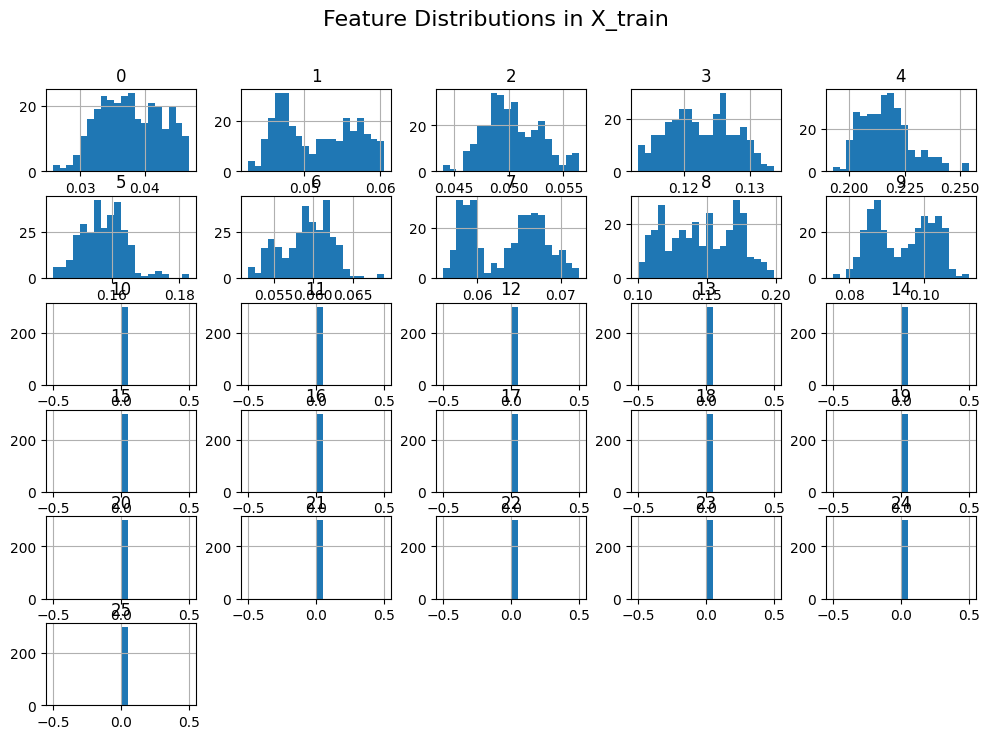

In [32]:
X_train_df = pd.DataFrame(X_train) 
X_train_df.hist(bins=20, figsize=(12, 8))
plt.suptitle('Feature Distributions in X_train', fontsize=16)
plt.show()


PURPOSE: To scale the training and testing data
REASON: due to the insights from the plot above, mentioned in the markdown box of the above code snippet

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


PURPOSE: Chi-square kernel function for the svm classifier and training the Non linear SVM model with chi-square kernel.

REASON: A direct implementation of a Chi-square kernel is generally not provided as a built-in kernel option in ML libraries (such as scikit-learn or TensorFlow) due to high computation overhead etc, leading to using a custom chi2 kernel.
LBP-TOP features are to be trained on a chi2 kernel
Other customised features like clipping kernel values is applied to avoid overflow that was noticed in the first run

In [ ]:
def chi_square_kernel(X, Y, threshold=100):
    # Compute the pairwise Chi-square kernel between the samples in X and Y
    numerator = np.sum((X[:, np.newaxis] - Y[np.newaxis, :])**2, axis=2)  # Pairwise squared differences
    denominator = np.sum(X[:, np.newaxis] + Y[np.newaxis, :], axis=2)  # Pairwise sum
    # Avoid division by zero
    denominator[denominator == 0] = 1e-6
    kernel_values = -0.5 * numerator / denominator
    # xlip kernel values to avoid overflow in the exponential function
    kernel_values = np.clip(kernel_values, -threshold, threshold)
    return np.exp(kernel_values)  # kernel matrix

svm_model = SVC(kernel=chi_square_kernel) #use the above chi2 kernel
svm_model.fit(X_train_scaled, Y_train)  #train the svm model


SVC(kernel=<function chi_square_kernel at 0x00000246F7C54B80>)

PURPOSE: test the model using the scaled test values and print metrics like accuracy, f1 score, precision, recall and confusion matrix
REASON: To analyse model performance. 

MODEL PERFORMANCE ANALYSIS:
The test accuracy is very low (~11%). 
POSSIBLE REASONS:
i. Low amount of labelled facial data and the amount considered in this run which contributes to the low accuracy.
ii. Data imbalance as seen from the confusion matrix and feature graphs can also be a reason for low accuracy. 
iii. Preprocessing methods in teh paper involve face detection and alignment (aligning the eyes). The paper suggests using Intraface(unavailable now) to detect fiducial points, leading to removal of some information during feature extraction.
iv. Also, the paper mentions that the winning team used CNN model, so other models might give a better accuracy than non linear chi2 kernel SVM 

Test Accuracy: 10.83%
Precision: 11.01%
Recall: 10.83%
F1 Score: 8.90%
Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        16
        Calm       0.12      0.19      0.15        16
     Disgust       0.09      0.06      0.07        16
     Fearful       0.00      0.00      0.00        16
       Happy       0.13      0.19      0.15        16
     Neutral       0.16      0.50      0.24         8
         Sad       0.07      0.06      0.07        16
   Surprised       0.33      0.06      0.11        16

    accuracy                           0.11       120
   macro avg       0.11      0.13      0.10       120
weighted avg       0.11      0.11      0.09       120

Confusion Matrix:
[[0 4 2 0 2 6 2 0]
 [2 3 1 1 4 2 2 1]
 [0 1 1 3 3 5 3 0]
 [2 9 1 0 1 2 0 1]
 [4 6 0 0 3 0 3 0]
 [0 0 1 0 3 4 0 0]
 [0 0 4 3 4 4 1 0]
 [4 2 1 0 3 2 3 1]]


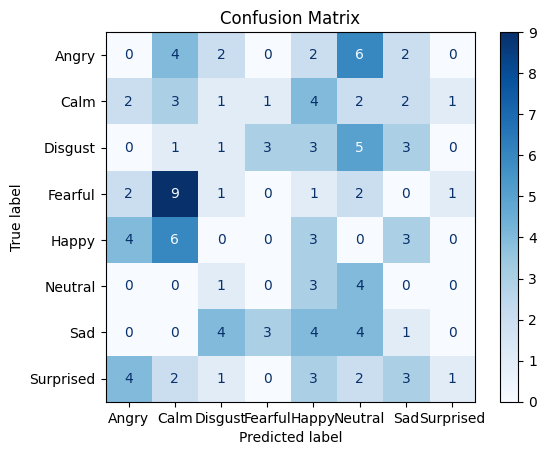

In [38]:
y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
precision = precision_score(Y_test, y_pred, average='weighted')  # Weighted for class imbalance
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print("Classification Report:")
print(classification_report(Y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)  #making the confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


PURPOSE: Save the model in a pickle file

In [18]:
import pickle
filename='save_svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(svm_model, file)

PURPOSE: Now applying SVM with rbf kernel to the training and testing dataset. Hyperparameter tuning using grid search is also done.
REASON: Apart from chi2, the rbf is also a non linear kernel used to detect and study images/frames from a video in this case. After using chi2, we are seeing how the data perfroms on another model. 
Hyperparameter tuning is also done using grid search to find the best parameters to test and train the model on. 
The accuracy is still less, but it doubles from 10.83% in chi2 kernel to 22.5% in rbf kernel.

In [41]:
param_grid = {    #the parameter grid
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}


svm = SVC()    #performing hyperparameter tuning 
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=8, scoring='accuracy')
grid_search.fit(X_train_scaled, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, Y_train)

# Evaluate the model
y_pred = best_svm.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Improved Accuracy: {accuracy * 100:.2f}%")


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Improved Accuracy: 22.50%


PURPOSE: finding metrics like accuracy, f1 score, recall, precision and confusion matrix.
REASON: to analyse the new svm model.

MODEL PERFORMANCE ANALYSIS:
i. The accuracy improved from 10.83% to 22.5%.
ii. The confusion matrix still shows data imbalance but it is better than the chi2 kernel model.
iii. The values of other metrics like precision, recall and f1 score significantly increased as compared to the previous model. 

Therefore, the rbf kernel SVM is the better model.

c:\Users\KIRTI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Accuracy: 99.67%
Test Accuracy: 22.50%
Precision: 31.07%
Recall: 22.50%
F1 Score: 21.51%


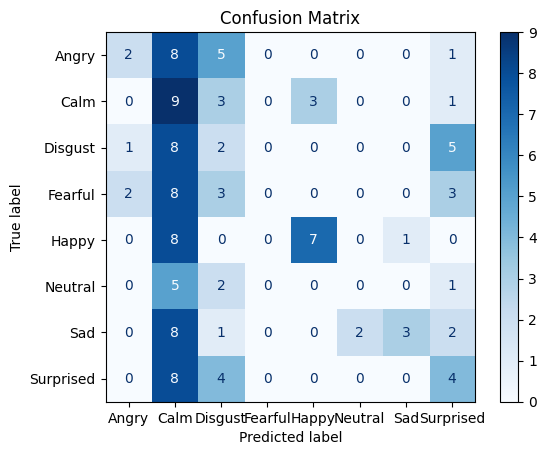

In [43]:
y_train_pred = best_svm.predict(X_train_scaled)   #prediction made on train and test dataset
y_test_pred = best_svm.predict(X_test_scaled)


train_accuracy = accuracy_score(Y_train, y_train_pred)   #calculating metrics
test_accuracy = accuracy_score(Y_test, y_test_pred)
precision = precision_score(Y_test, y_test_pred, average='weighted')  # Weighted for class imbalance
recall = recall_score(Y_test, y_test_pred, average='weighted')
f1 = f1_score(Y_test, y_test_pred, average='weighted')

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")  #printing the metrics
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

cm = confusion_matrix(Y_test, y_test_pred)  #printing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


PURPOSE: Code for saving the rbf kernel svm model and for loading it. 

In [42]:
filename='rbf_svm.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_svm, file)

In [19]:
with open('save_svm_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)